In [29]:
import models
from loader import Loader
from copy import deepcopy
import torch

from edit_heuristics import FromLayerHeuristic, SingleLayerHeuristic
from set_heuristics import SetHeuristic, SubsetSetHeuristic

ROOT = "./data"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = f"{ROOT}/moon_classifier_mlp.pth"
DATASET_PATH = f"{ROOT}/moon_dataset.pt"
EDITSET_PATH = f"{ROOT}/moon_misclassifications.pt"
EDITED_MODEL_PATH = f"{ROOT}/moon_classifier_mlp_edited.pth"

model = models.mlp(path=MODEL_PATH)
moon_data = torch.load(DATASET_PATH)
moon_dataset = torch.utils.data.TensorDataset(moon_data['features'], moon_data['labels'])

edit_heuristic = SingleLayerHeuristic(
    layer_idx=-1,
    lb=-0.1,
    ub=0.1,
)

set_heuristic = SubsetSetHeuristic(
    filename=EDITSET_PATH,
    device=DEVICE,
    dtype=torch.float32,
    indices=torch.tensor([3])
)

loader = Loader(
    model=model,
    edit_heuristic=edit_heuristic,
    set_heuristic=set_heuristic,
    dataset=moon_dataset,
)

loader.edit_and_test_model()
loader.save_model(EDITED_MODEL_PATH)

[00:54:30] INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.9800, Loss: 0.0886
Model saved to ./data/moon_classifier_mlp_edited.pth


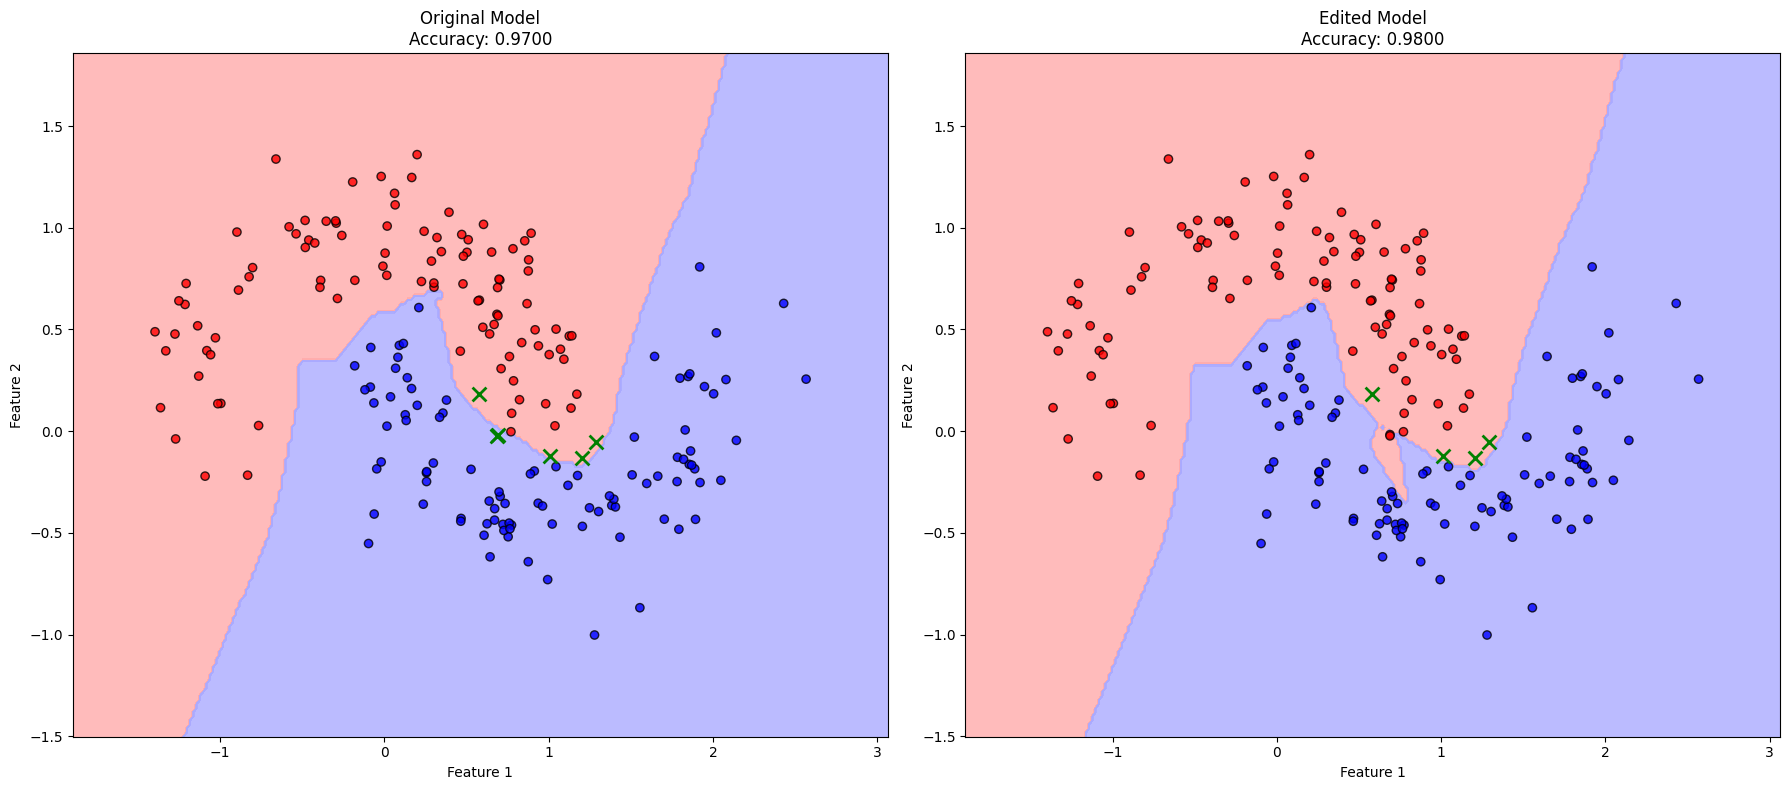

Original model correctness: 0.9700
Original model accuracy: 194 / 200
Edited model correctness: 0.9800
Edited model accuracy: 196 / 200
Number of samples fixed by editing: 2
Number of new errors introduced: 0


In [30]:
from matplotlib.colors import ListedColormap
import numpy as np
import torch

import matplotlib.pyplot as plt

def compare_models_decision_boundary(original_model, edited_model, X, y):
    """
    Compare decision boundaries and misclassifications of original and edited models.
    
    Args:
        original_model: The original MLP model
        edited_model: The edited MLP model
        X: Input features tensor/numpy array
        y: True labels tensor/numpy array
    """
    # Convert inputs to numpy if they're tensors
    if isinstance(X, torch.Tensor):
        X = X.numpy()
    if isinstance(y, torch.Tensor):
        y = y.numpy()
    
    # Create a mesh grid for decision boundary visualization
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    mesh_input = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    
    # Set up the figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Loop through both models
    for i, (title, model) in enumerate([('Original Model', original_model), ('Edited Model', edited_model)]):
        # Get predictions for the mesh
        with torch.no_grad():
            mesh_output = model(mesh_input)
            Z = torch.argmax(mesh_output, dim=1).reshape(xx.shape).detach().numpy()
            
            # Get predictions for the test points
            outputs = model(torch.FloatTensor(X))
            _, predicted = torch.max(outputs.data, 1)
        
        # Convert to numpy
        predicted = predicted.numpy()
        
        # Plot decision boundary
        axes[i].contourf(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.8)
        
        # Plot correct classifications
        correct_idx = (predicted == y)
        axes[i].scatter(X[correct_idx, 0], X[correct_idx, 1], 
                  c=y[correct_idx], cmap=ListedColormap(['#FF0000', '#0000FF']), 
                  edgecolors='k', alpha=0.8)
        
        # Plot misclassifications with green X
        misclass_idx = (predicted != y)
        axes[i].scatter(X[misclass_idx, 0], X[misclass_idx, 1], 
                  c='green', marker='x', s=100, linewidths=2)
        
        # Calculate and display accuracy
        accuracy = (predicted == y).mean()
        axes[i].set_title(f"{title}\nAccuracy: {accuracy:.4f}")
        axes[i].set_xlabel('Feature 1')
        axes[i].set_ylabel('Feature 2')
    
    plt.tight_layout()
    plt.show()
    
    # Print the number of misclassifications for each model
    with torch.no_grad():
        original_preds = torch.argmax(original_model(torch.FloatTensor(X)), dim=1).numpy()
        edited_preds = torch.argmax(edited_model(torch.FloatTensor(X)), dim=1).numpy()
        
        original_misclass = (original_preds != y).sum()
        edited_misclass = (edited_preds != y).sum()
        
        print(f"Original model correctness: {(original_preds == y).mean():.4f}")
        print(f"Original model accuracy: {len(y) - original_misclass} / {len(y)}")
        print(f"Edited model correctness: {(edited_preds == y).mean():.4f}")
        print(f"Edited model accuracy: {len(y) - edited_misclass} / {len(y)}")
        
        # Show which samples were fixed by editing
        fixed_samples = np.where((original_preds != y) & (edited_preds == y))[0]
        new_errors = np.where((original_preds == y) & (edited_preds != y))[0]
        
        print(f"Number of samples fixed by editing: {len(fixed_samples)}")
        print(f"Number of new errors introduced: {len(new_errors)}")

# Load the original model
original_model = models.mlp(path=MODEL_PATH)

# Load the edited model
edited_model = deepcopy(model)
edited_model.load_state_dict(torch.load(EDITED_MODEL_PATH, map_location=DEVICE))

# Get the test data features and labels from the moon_dataset
X = moon_data['features']
y = moon_data['labels']

# Compare the models
compare_models_decision_boundary(original_model, edited_model, X, y)